In [499]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [321]:
# read the csv file and get basic info
df = pd.read_csv('cost.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Columns: 152 entries, 199 to 137.3
dtypes: int64(152)
memory usage: 186.6 KB


,199,192,192.1,196,193,193.1,190,188,179,179.1,...,122,122.1,129,138,139,139.1,137,137.1,137.2,137.3
0,196,202,202,197,189,189,190,177,182,182,...,137,137,126,135,138,138,139,137,137,138
1,196,202,202,197,189,189,190,177,182,182,...,137,137,126,135,138,138,139,137,137,138
2,186,187,187,200,187,187,186,182,182,182,...,147,147,131,136,136,136,137,138,138,141
3,193,185,185,185,193,193,190,190,184,184,...,139,139,128,127,133,133,136,137,137,141
4,193,185,185,185,193,193,190,190,184,184,...,139,139,128,127,133,133,136,137,137,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,27,23,23,17,23,23,30,36,39,39,...,199,199,199,200,201,201,201,200,200,193
153,29,24,24,17,22,22,33,41,50,50,...,196,196,198,197,195,195,193,188,188,182
154,31,22,22,17,23,23,33,43,53,53,...,191,191,194,191,189,189,186,178,178,175
155,31,22,22,17,23,23,33,43,53,53,...,191,191,194,191,189,189,186,178,178,175


In [441]:
# convert to numpy array to ensure integer
# costs = df.to_numpy(dtype=int)
costs = np.loadtxt("cost.csv", delimiter=",", dtype=int)

# point with minimum costs
minimum = sorted([np.where(costs == np.amin(costs))[i][0] for i in range(2)])
print(minimum)
# point with maximum costs
maximum = sorted([np.where(costs == np.amax(costs))[i][0] for i in range(2)])
print(maximum)

[43, 144]
[3, 35]
255


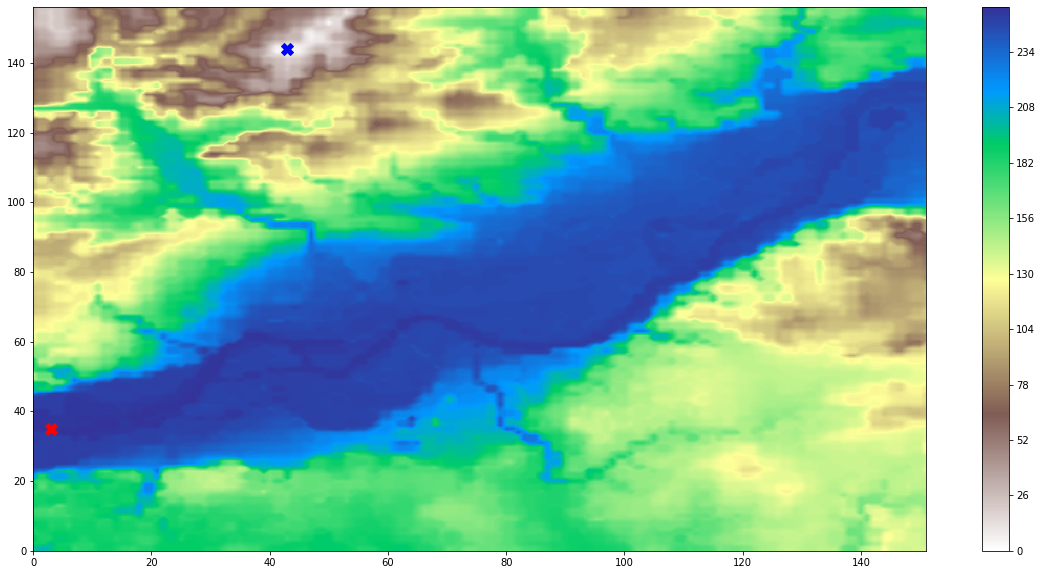

In [442]:
# explore the data
plt.rcParams["figure.figsize"] = (20,10)
plt.contourf(df, levels=255, cmap='terrain_r')
plt.plot(*minimum, 'rX', color="blue", markersize=12)
plt.plot(*maximum, 'rX', markersize=12)
plt.colorbar()
plt.show()

In [443]:
# cost function with error handling
def cost_func(x, y):
    if x < 0 or y < 0:  
        return np.amax(costs)+1 # return high costs
    try:
        return costs[x, y]
    except IndexError:
        return np.amax(costs)+1 # return high costs

In [452]:
def nelder_mead(data, alpha, sigma, gamma, rho, t, points):
        
    # creating numpy array
    dt = np.dtype(dtype=[('point', int, 2), ('cost', int)])
    simplex = np.array(points, dtype=dt)
    # add costs to every point in the simplex
    simplex['cost'] = [cost_func(*point) for point in simplex['point']]
     
    while True:
        # sort points by cost
        simplex = np.sort(simplex, order="cost")
#         print(f'new simplex:\n{simplex[0]}\n{simplex[1]}\n{simplex[2]}')
        
        x_best = simplex['point'][0]
        x_second_worst = simplex['point'][-2]
        x_worst = simplex['point'][-1]
        
        # calculate the centroid of the simplex. The centroid does not include the worst point
        x_centroid = np.mean(simplex['point'][:2], dtype=int)
        
        # calculated points
        x_reflected = alpha * (x_centroid - x_worst) + x_centroid
        x_expanded = x_centroid + (gamma * x_reflected - x_centroid)
        x_contracted = x_centroid + (rho * (x_worst - x_centroid)).astype(int)
                        
        if np.std(simplex['cost']) < t and (np.std(simplex['point'], axis=0) == 0).all():
            break
            
        # reflection
        if cost_func(*x_best) <= cost_func(*x_reflected) < cost_func(*x_second_worst):
            simplex[-1] = x_reflected, cost_func(*x_reflected)
            print(f'Reflected to {x_reflected} with costs {cost_func(*x_reflected)}')
        
        # reflection expansion
        elif cost_func(*x_reflected) < cost_func(*x_best):
            if cost_func(*x_expanded) < cost_func(*x_reflected):
                simplex[-1] = x_expanded, cost_func(*x_expanded)
                print(f'Expanded to {x_reflected} with costs {cost_func(*x_reflected)}')

            else:
                simplex[-1] = x_reflected, cost_func(*x_reflected)
                print(f'Reflected to {x_expanded} with costs {cost_func(*x_expanded)}')
                      
        # contraction
        else:
            if cost_func(*x_contracted) < cost_func(*x_worst):
                simplex[-1] = x_contracted, cost_func(*x_contracted)
                print(f'Contracted to {x_contracted} with new costs {cost_func(*x_contracted)}')
            
            # shrink
            else:
                x_shrunk = x_best + (sigma * (simplex['point'][-2:] - x_best)).astype(int)
                simplex['point'][-2:] = x_shrunk
                simplex['cost'][-2:] = [cost_func(*point) for point in simplex['point'][-2:]] 
                print(f'Shrunk to:\n{simplex[0]}\n{simplex[1]}\n{simplex[2]}')
        
    return x_best

In [479]:
simplex_start = [((75,75), cost_func(75,75)), 
                 ((157,8), cost_func(157,8)), 
                 ((147,100), cost_func(147,100))]

    
# random restart, Ecken, günstigen Durchlauf
# Mimimum ist der Lärchenberg

optimum = nelder_mead(data=costs,
                      alpha=1, 
                      sigma=0.5, 
                      gamma=2, 
                      rho=0.5, 
                      t=2, 
                      points=simplex_start)

print("Optimum:", optimum, '\ncost:', cost_func(*optimum))

Contracted to [89 89] with new costs 245
Contracted to [96 96] with new costs 243
Contracted to [100 100] with new costs 241
Shrunk to:
([157,   8], 68)
([152,  54], 64)
([129,  54], 102)
Shrunk to:
([152,  54], 64)
([154,  31], 58)
([141,  54], 49)
Shrunk to:
([141,  54], 49)
([147,  43], 17)
([146,  54], 43)
Shrunk to:
([147,  43], 17)
([147,  48], 11)
([144,  48], 30)
Shrunk to:
([147,  48], 11)
([147,  46], 12)
([146,  48], 21)
Shrunk to:
([147,  48], 11)
([147,  47], 8)
([147,  48], 11)
Shrunk to:
([147,  47], 8)
([147,  47], 8)
([147,  47], 8)
Optimum: [147  47] 
cost: 8


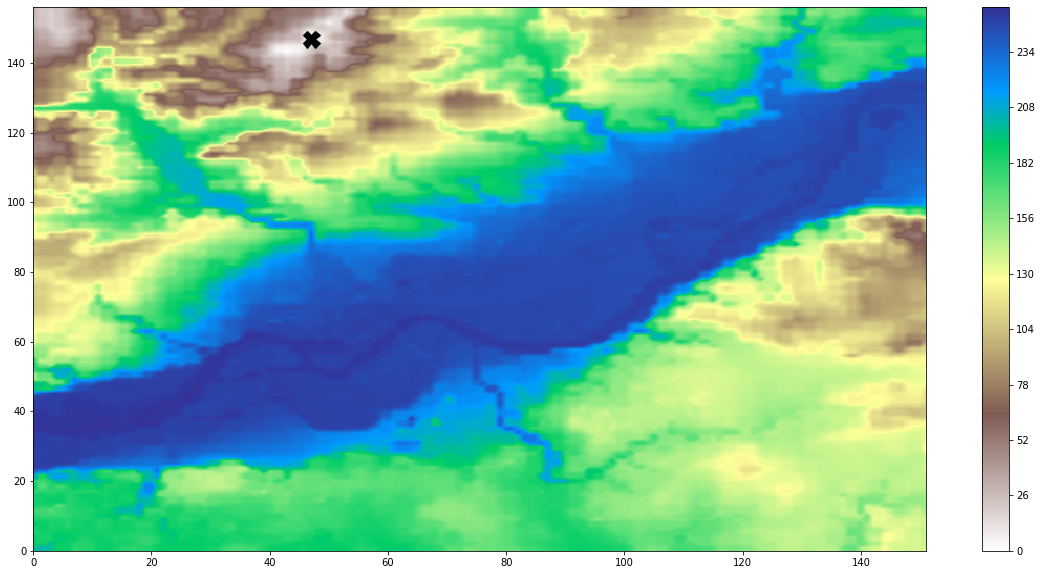

In [521]:
plt.rcParams["figure.figsize"] = (20,10)
plt.contourf(df, levels=255, cmap='terrain_r')
plt.plot(optimum[1], optimum[0], 'rX', markersize=17, color="black")
plt.colorbar()
plt.show()

In [501]:
def function(x):
    a,b = x
    return (1.5 - a + a * b) ** 2 +\
           (2.25 - a + a * b ** 2) ** 2 +\
           (2.625 - a + a * b ** 3) ** 2

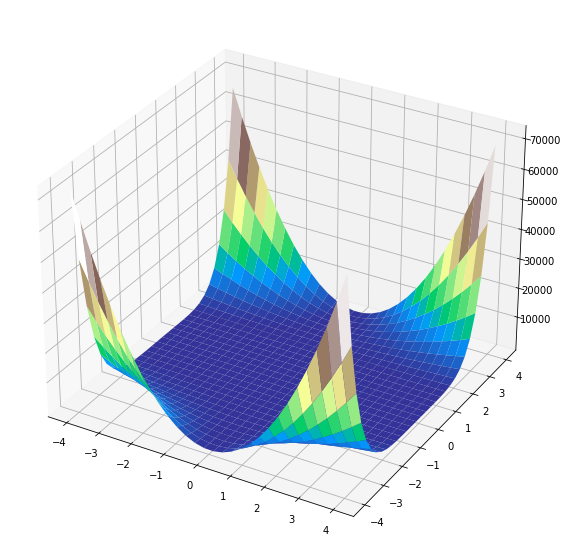

In [508]:
x = np.outer(np.linspace(-4, 4, 30), np.ones(30))
y = x.copy().T
z = function((x, y))

plt.rcParams["figure.figsize"] = (20,10)
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, cmap='terrain')
plt.show()

In [515]:
print(minimize(function, [0, 0], method='CG'))

     fun: 5.825822747402427e-11
     jac: array([-5.26310215e-06, -2.94182541e-06])
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 10
    njev: 19
  status: 0
 success: True
       x: array([2.99998094, 0.4999952 ])


In [506]:
def gradient(values):
    x, y = values
    return 2 * ((1.5 - x + x * y) * np.array([-1 + y, x]) +
                (2.25 - x + x * y ** 2) * np.array([-1 + y ** 2, 2 * x * y]) +
                (2.625 - x + x * y ** 3) * np.array([-1 + y ** 3, 3 * x * y **2]))

In [514]:
print(minimize(function, [0, 0], method='CG', jac=gradient))

     fun: 1.6405513553900587e-14
     jac: array([ 2.82251570e-07, -1.21100298e-06])
 message: 'Optimization terminated successfully.'
    nfev: 19
     nit: 10
    njev: 19
  status: 0
 success: True
       x: array([2.99999994, 0.49999996])


In [ ]:
# wie funktioniert die optimize Funktion, welche Parameter sind wichtig?
# mit Ableitung findet er in weniger Durchläufen das Ergebnis

In [510]:
# runtime comparison
%timeit minimize(function, np.array([0.0, 0.0]), method='CG')

979 µs ± 68 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [511]:
%timeit minimize(function, np.array([0.0, 0.0]), method='CG', jac=gradient)

860 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
